In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
titanic = pd.read_csv("/kaggle/input/titanic/train.csv")
df = titanic.copy()

# Understand The dataset

In [3]:
# head of the dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#tail of the dataset
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
#Shape of the datset
df.shape

(891, 12)

In [6]:
#types of the datset
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
#info of the datset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
#describe 
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Feature Enginnering

In [10]:
# Anaylsis of Categorical and Numerical Variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car, num_but_cat

In [11]:
df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')
df["NEW_NAME_LETTER_COUNT"] = df["Name"].str.len()
df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))
df["NEW_NAME_DR"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
df["NEW_TITLE"] = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1
df["NEW_AGE_PCLASS"] = df["Pclass"] * df["Age"]
df.loc[((df["SibSp"] + df["Parch"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SibSp"] + df["Parch"]) == 0), "NEW_IS_ALONE"] = "Yes"
df.loc[(df["Age"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["Age"] >= 18) & (df["Age"] < 55), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 55), "NEW_AGE_CAT"] = "senior"
df.loc[(df["Sex"] == "male") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["Sex"] == "male") & ((df["Age"] > 21) & (df["Age"] < 50)), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["Sex"] == "male") & (df["Age"] >= 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["Sex"] == "female") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["Sex"] == "female") & ((df["Age"] > 21) & (df["Age"] < 50)), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["Sex"] == "female") & (df["Age"] >= 50), "NEW_SEX_CAT"] = "seniorfemale"

In [12]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"Num_but_cat: {len(num_but_cat)}")

Observations: 891
Variables: 22
Cat_cols: 14
Num_cols: 5
Cat_but_car: 3
Num_but_cat: 8


In [13]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"Num_but_cat: {len(num_but_cat)}")

Observations: 891
Variables: 22
Cat_cols: 14
Num_cols: 5
Cat_but_car: 3
Num_but_cat: 8


# work on Outlier

In [14]:
def outlier_threshold(dataframe, col_name, q1=0.05, q3=0.95):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit, up_limit

In [15]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_threshold(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [16]:
def replace_with_thresholds_dataframe(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    replace_with_thresholds(dataframe, col)

In [17]:
replace_with_thresholds_dataframe(df)

/tmp/ipykernel_17/3022633631.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-30.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit


# work on minnsing values 

In [18]:
def missing_value_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss","ratio"])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

In [19]:
na_columns = missing_value_table(df, na_name=True)

                n_miss  ratio
Cabin              687  77.10
Age                177  19.87
NEW_AGE_PCLASS     177  19.87
NEW_AGE_CAT        177  19.87
NEW_SEX_CAT        177  19.87
Embarked             2   0.22


In [20]:
remove_cols = ["Name", "Ticket", "Cabin"]
df.drop(remove_cols, axis=1, inplace=True)

In [21]:
na_columns = missing_value_table(df, na_name=True)


                n_miss  ratio
Age                177  19.87
NEW_AGE_PCLASS     177  19.87
NEW_AGE_CAT        177  19.87
NEW_SEX_CAT        177  19.87
Embarked             2   0.22


In [22]:
df["Age"] = df["Age"].fillna(df.groupby("NEW_TITLE")["Age"].transform("median"))


In [23]:
na_columns = missing_value_table(df, na_name=True)


                n_miss  ratio
NEW_AGE_PCLASS     177  19.87
NEW_AGE_CAT        177  19.87
NEW_SEX_CAT        177  19.87
Embarked             2   0.22


In [24]:
df["NEW_AGE_PCLASS"] = df["Pclass"] * df["Age"]
df.loc[((df["SibSp"] + df["Parch"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SibSp"] + df["Parch"]) == 0), "NEW_IS_ALONE"] = "Yes"
df.loc[(df["Age"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["Age"] >= 18) & (df["Age"] < 55), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 55), "NEW_AGE_CAT"] = "senior"
df.loc[(df["Sex"] == "male") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["Sex"] == "male") & ((df["Age"] > 21) & (df["Age"] < 50)), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["Sex"] == "male") & (df["Age"] >= 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["Sex"] == "female") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["Sex"] == "female") & ((df["Age"] > 21) & (df["Age"] < 50)), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["Sex"] == "female") & (df["Age"] >= 50), "NEW_SEX_CAT"] = "seniorfemale"

In [25]:
na_columns = missing_value_table(df, na_name=True)


          n_miss  ratio
Embarked       2   0.22


In [26]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype in ["category", "object"] and len(x.unique())<=10) else x, axis=0)

In [27]:
na_columns = missing_value_table(df, na_name=True)


Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [28]:
df.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NEW_CABIN_BOOL,NEW_NAME_LETTER_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,male,22.0,1,0,7.2500,S,0,23.0,4,0,Mr,2,66.0,NO,mature,maturemale
1,2,1,1,female,38.0,1,0,71.2833,C,1,51.0,7,0,Mrs,2,38.0,NO,mature,maturefemale
2,3,1,3,female,26.0,0,0,7.9250,S,0,22.0,3,0,Miss,1,78.0,Yes,mature,maturefemale
3,4,1,1,female,35.0,1,0,53.1000,S,1,44.0,7,0,Mrs,2,35.0,NO,mature,maturefemale
4,5,0,3,male,35.0,0,0,8.0500,S,0,24.0,4,0,Mr,1,105.0,Yes,mature,maturemale


In [29]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [30]:
def label_encoder_dataframe(dataframe):
  binary_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ["int", "float"] and dataframe[col].nunique() == 2]
  for col in binary_cols:
    label_encoder(dataframe, col)

In [31]:
label_encoder_dataframe(df)


In [32]:
df.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NEW_CABIN_BOOL,NEW_NAME_LETTER_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,1,22.0,1,0,7.2500,S,0,23.0,4,0,Mr,2,66.0,0,mature,maturemale
1,2,1,1,0,38.0,1,0,71.2833,C,1,51.0,7,0,Mrs,2,38.0,0,mature,maturefemale
2,3,1,3,0,26.0,0,0,7.9250,S,0,22.0,3,0,Miss,1,78.0,1,mature,maturefemale
3,4,1,1,0,35.0,1,0,53.1000,S,1,44.0,7,0,Mrs,2,35.0,0,mature,maturefemale
4,5,0,3,1,35.0,0,0,8.0500,S,0,24.0,4,0,Mr,1,105.0,1,mature,maturemale


In [33]:
def one_hot_encoding(dataframe, drop_first=True):
  label_encoder_dataframe(dataframe)
  cat_cols = [col for col in dataframe.columns if 20 >= dataframe[col].nunique() > 2]
  dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
  return dataframe

In [34]:
df = one_hot_encoding(df)
df.head()

,PassengerId,Survived,Sex,Age,Fare,NEW_CABIN_BOOL,NEW_NAME_LETTER_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,...,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.0,7.2500,0,23.0,0,66.0,0,...,False,False,False,False,False,True,False,False,False,False
1,2,1,0,38.0,71.2833,1,51.0,0,38.0,0,...,False,False,False,False,False,False,False,False,False,False
2,3,1,0,26.0,7.9250,0,22.0,0,78.0,1,...,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.0,53.1000,1,44.0,0,35.0,0,...,False,False,False,False,False,False,False,False,False,False
4,5,0,1,35.0,8.0500,0,24.0,0,105.0,1,...,False,False,False,False,False,True,False,False,False,False


In [35]:
def robust_scaler(dataframe, num_col):
  temp_df = dataframe.copy()
  rs = RobustScaler()
  temp_df[num_col] = rs.fit_transform(temp_df[[num_col]])
  return temp_df

In [36]:
def robust_scaler_dataframe(dataframe):
  temp_df = dataframe.copy()
  rs = RobustScaler()
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    temp_df[col] = rs.fit_transform(temp_df[[col]])
  return temp_df

In [37]:
df = robust_scaler_dataframe(df)


In [38]:
df.drop("PassengerId", axis=1, inplace=True)


In [39]:
df.head()

,Survived,Sex,Age,Fare,NEW_CABIN_BOOL,NEW_NAME_LETTER_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,Pclass_2,...,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,0,1,-0.571429,-0.312011,0,-0.2,0,0.08,0,False,...,False,False,False,False,False,True,False,False,False,False
1,1,0,0.571429,2.461242,1,2.6,0,-0.48,0,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0,-0.285714,-0.282777,0,-0.3,0,0.32,1,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0,0.357143,1.673732,1,1.9,0,-0.54,0,False,...,False,False,False,False,False,False,False,False,False,False
4,0,1,0.357143,-0.277363,0,-0.1,0,0.86,1,False,...,False,False,False,False,False,True,False,False,False,False


In [40]:
def RF_Model_FI(dataframe, target, test_size=0.30, save=False):
  y = dataframe[target]
  X = dataframe.drop(target, axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=17)
  rf_model = RandomForestClassifier(random_state=17).fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)

  print(15*"#", "Model Metrics Using Feature Engineering", 15*"#")
  print(f"Acuuracy: {round(accuracy_score(y_pred, y_test), 2)}")
  print(f"Recall: {round(recall_score(y_pred, y_test), 2)}")
  print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
  print(f"ROC_AUC: {round(roc_auc_score(y_pred, y_test), 2)}")
  print(f"F1: {round(f1_score(y_pred, y_test), 2)}")

  feature_imp = pd.DataFrame({'Value': rf_model.feature_importances_, 'Feature': X.columns})
  plt.figure(figsize=(14,14))
  sns.set(font_scale=1)
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
  plt.title("Features")
  plt.tight_layout()
  if save:
    plt.savefig("importance_features.jpg")


############### Model Metrics Using Feature Engineering ###############
Acuuracy: 0.8
Recall: 0.79
Precision: 0.69
ROC_AUC: 0.8
F1: 0.74


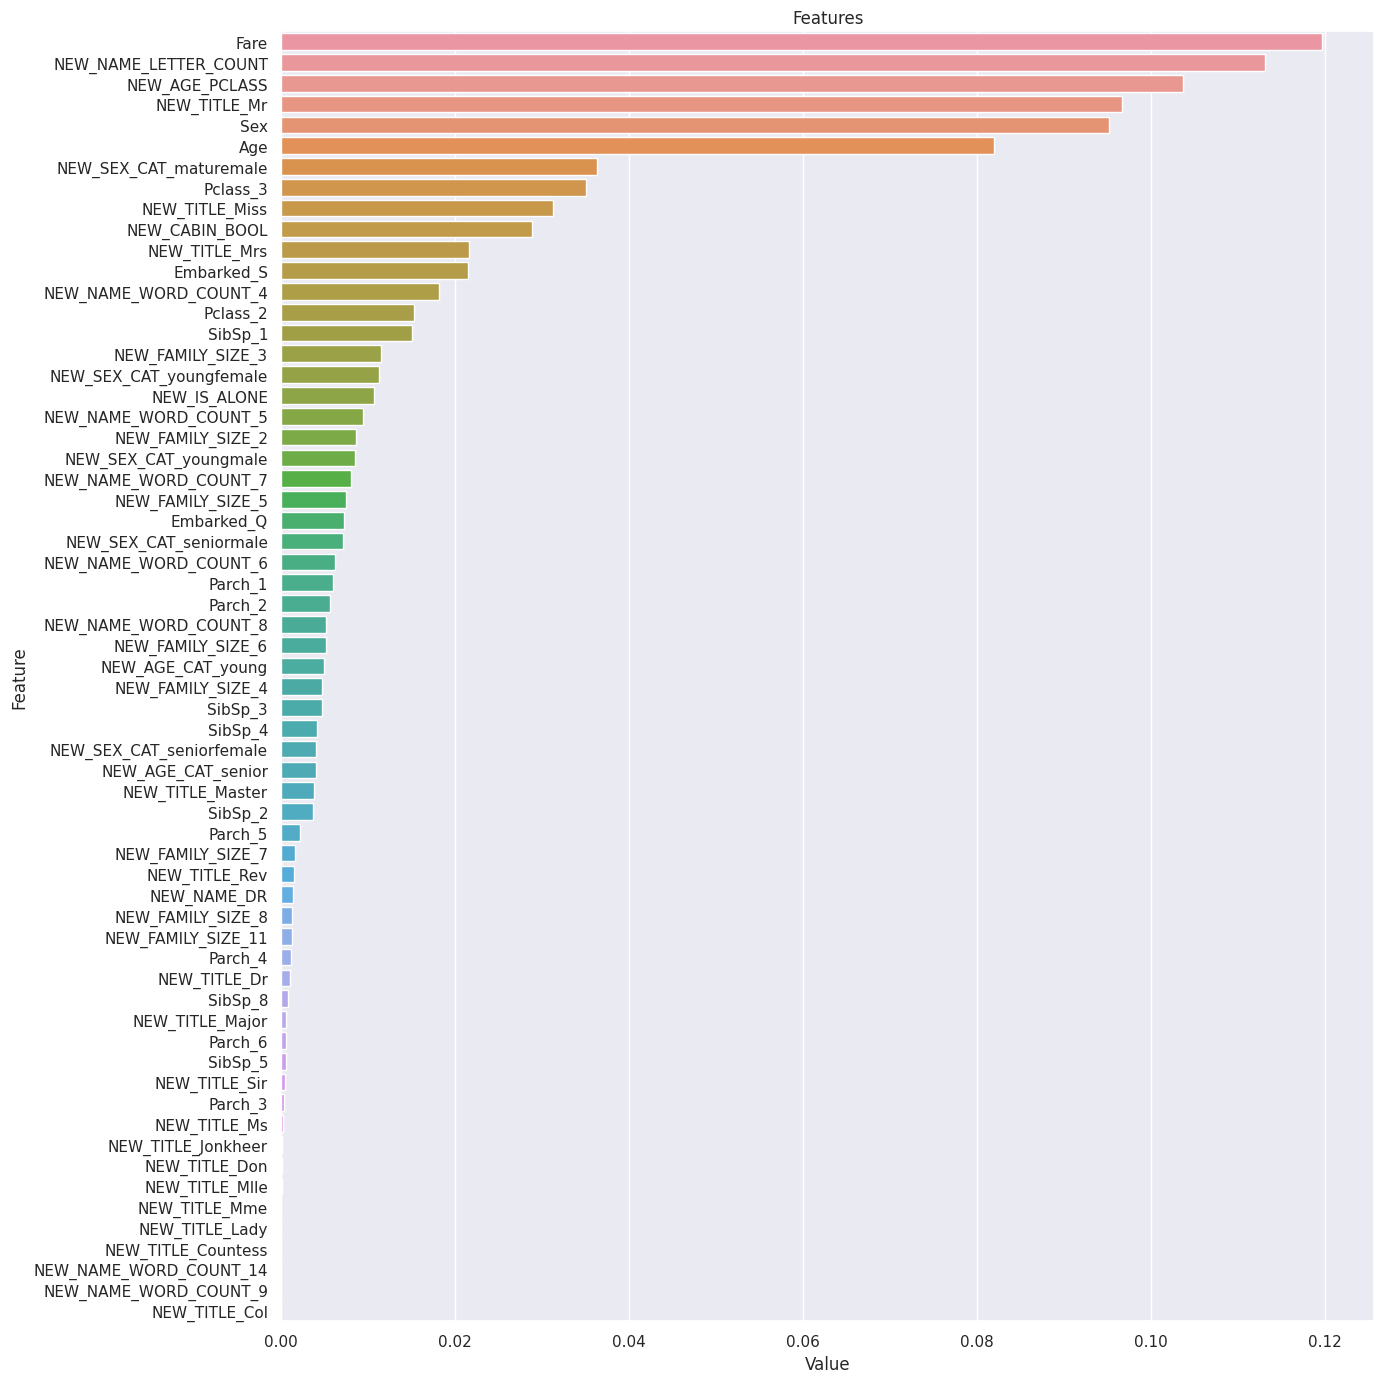

In [41]:
RF_Model_FI(df, "Survived")


# For testing we apply regression models 

############### Model Metrics Using Feature Engineering ###############
Mean Squared Error: 0.16
Mean Absolute Error: 0.27
R2 Score: 0.32


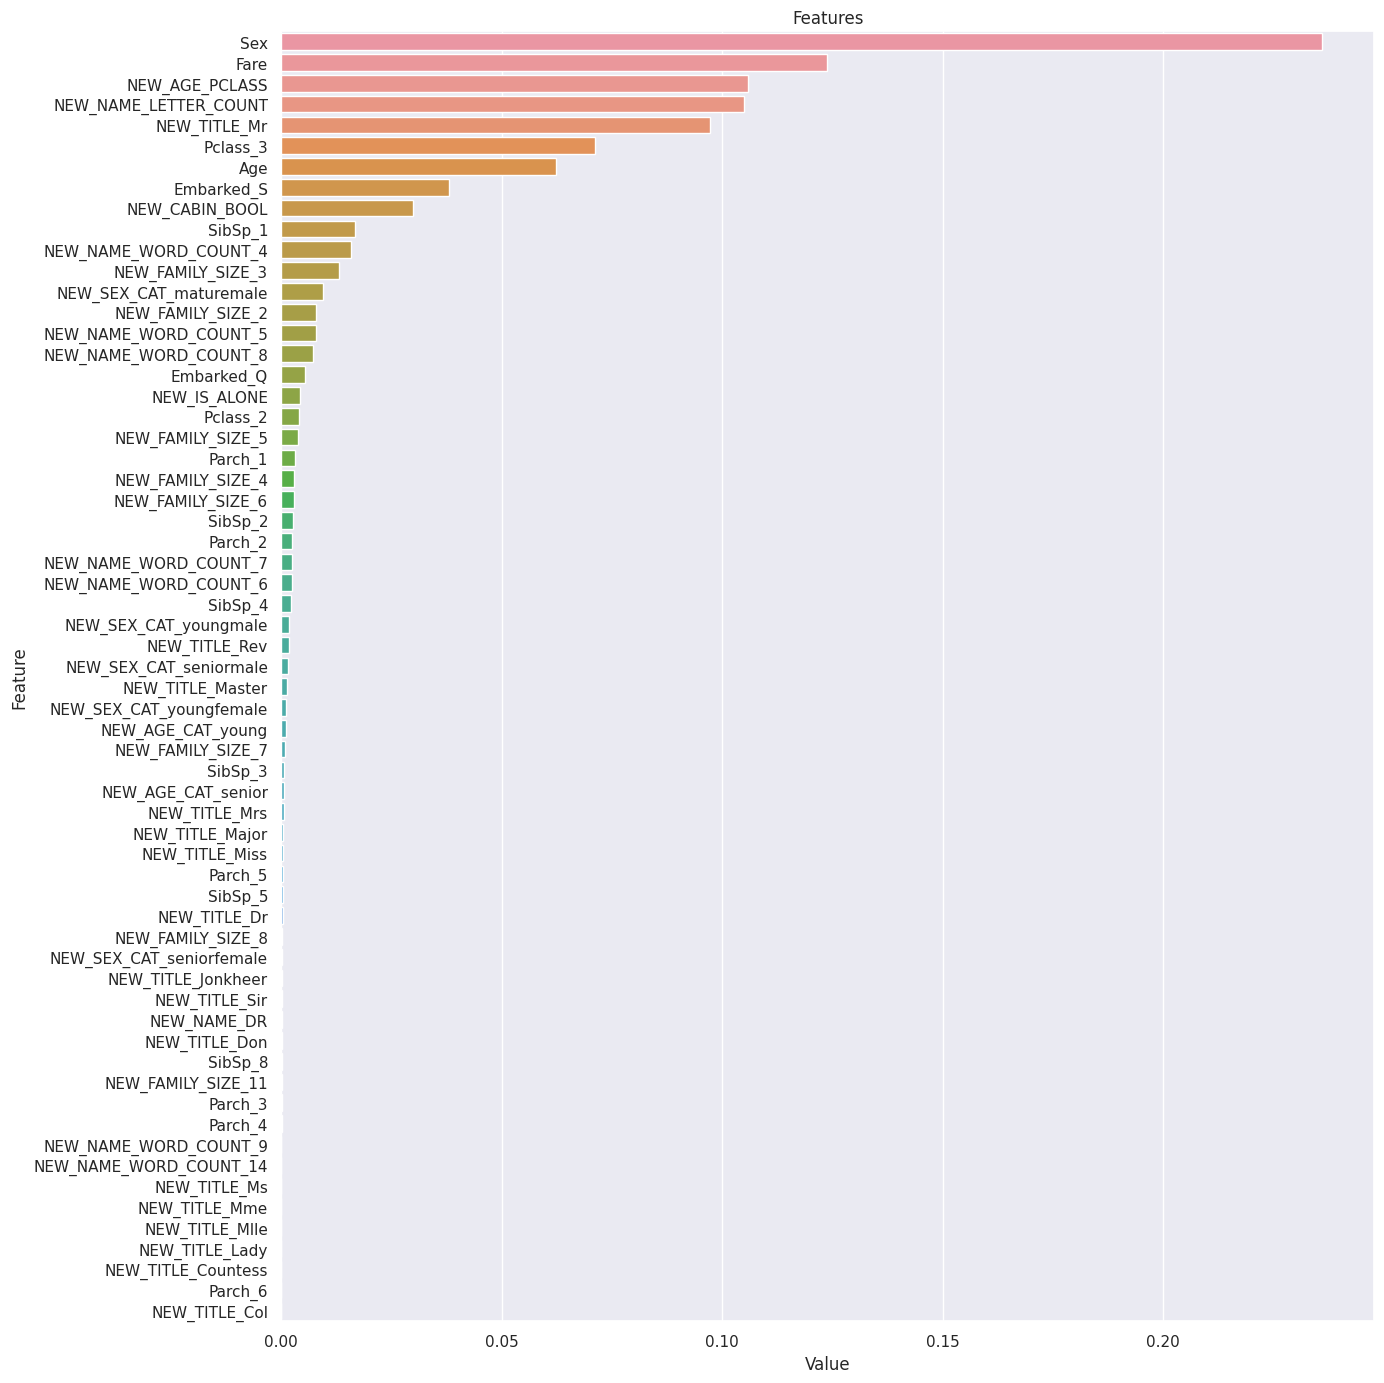

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def RF_Model_FI_Regression(dataframe, target, test_size=0.30, save=False):
    y = dataframe[target]
    X = dataframe.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=17)
    
    rf_model = RandomForestRegressor(random_state=17)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    print(15*"#", "Model Metrics Using Feature Engineering", 15*"#")
    print(f"Mean Squared Error: {round(mean_squared_error(y_test, y_pred), 2)}")
    print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, y_pred), 2)}")
    print(f"R2 Score: {round(r2_score(y_test, y_pred), 2)}")

    feature_imp = pd.DataFrame({'Value': rf_model.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(14,14))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title("Features")
    plt.tight_layout()
    if save:
        plt.savefig("importance_features_regression.jpg")

# Example usage for regression
# Example usage for regression
RF_Model_FI_Regression(df, "Survived")

